In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
/kaggle/input/facebook-recruiting-iii-keyword-extraction/SampleSubmission.csv
/kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip


# ::::PROJECT OBJECTIVES::::
1.EDA of the questions asked on Stack Exchange.
2.Application of various visualization techniques to draw important conclusions about data.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [3]:
if not os.path.isfile('train.db'):
  
    disk_engine = create_engine('sqlite:///train.db')
  
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('../input/facebook-recruiting-iii-keyword-extraction/Train.zip',compression='zip', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
if os.path.isfile('train.db'):
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")


180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Number of rows in the database : 
 6034196


We are writing this code to get the count of duplicate rows and to remove duplicates.
It is important to understand how many questions are getting duplicated.

In [4]:
if os.path.isfile('train.db'):
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")


In [5]:
 df_no_dup.head()


,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [6]:
df_no_dup.dtypes
a=df_no_dup.shape[0]-1
b=np.arange(a)
print(a)
df_no_dup.dropna(inplace=True)
df_no_dup.reset_index(drop=True)


4206314


,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2
...,...,...,...,...
4206303,（wordpress）Plugin Error:You do not have suffic...,<p>My plugin which adds a menu in admin page h...,wordpress wordpress-plugin,2
4206304,� (question mark) getting displayed in place o...,<p>Everytime i get some text to display on a p...,php mysql text,1
4206305,� appears using character_limiter() with strip...,<p>I'm getting � characters when I combine Cod...,php codeigniter character-encoding,1
4206306,� in base64 encoded emails,<p>I have a problem with Swedish language + MS...,php email outlook mime,2


After removing duplicates we removed about 2 million of data points.

In [7]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")
df_no_dup.cnt_dup.value_counts()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
df_no_dup.tag_count.value_counts()
df_no_dup.head()

number of duplicate questions : 1827888 ( 30.29215491177284 % )


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


Column 1 represents frequency of repitition and column 2 the number of datapoints.

In [25]:
df_no_dup.cnt_dup.value_counts()


1    2656278
2    1272335
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

Similary here we are getting the number of tags vs number of data points

In [26]:
df_no_dup.tag_count.value_counts()


3    1206157
2    1111706
4     814996
1     568291
5     505158
Name: tag_count, dtype: int64

In [8]:
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [9]:
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    con.close()

    tag_data.drop(tag_data.index[0], inplace=True)
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")


Time taken to run this cell : 0:01:19.768594


In [10]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])


Creating a list of tags that are present

In [11]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[:20])


Number of data points : 4206307
Number of unique tags : 42048
Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store', '.each', '.emf', '.exe', '.exe.config', '.hgtags', '.htaccess', '.htpasswd', '.ico', '.lib', '.lrc']


In [12]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [13]:
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


**TAGS VS THE NUMBER OF TIMES THEY APPEAR**

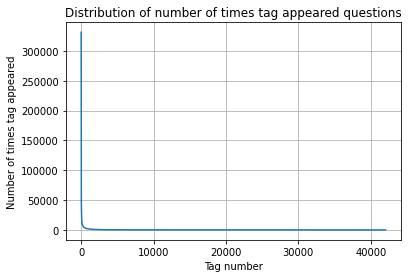

In [14]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

**GOING CLOSER TO ACTUALLY GET THE ELBOW POINT**

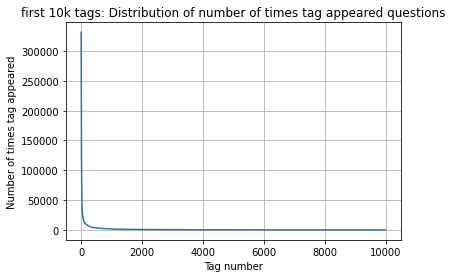

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2986   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    374    370    367    365
  

In [15]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])


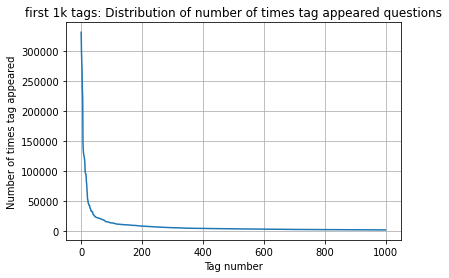

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2986   2983   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [16]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])


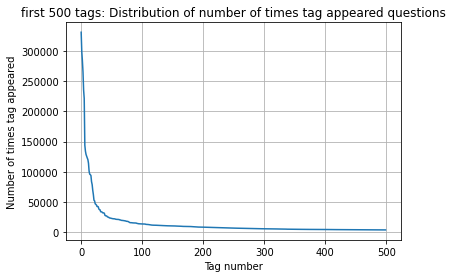

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [17]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])


**FINALLY REACHING A VISUAL ELBOW**

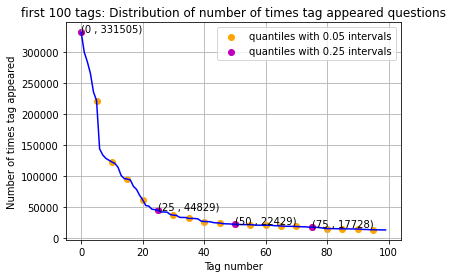

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [18]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])


ANALYSIS OF TAGS PER QUESTION

In [19]:
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))


153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


**NOW WE WILL ANALYZE THE NUMBER OF TAGS PER QUESTION**

In [20]:
tag_quest_count = tag_dtm.sum(axis=1).tolist()
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206307 datapoints.
[3, 4, 2, 2, 3]


In [21]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))


Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899443


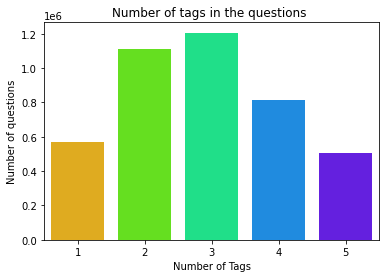

In [22]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

**WORD CLOUD TO GET THE VISUAL IDEA OF TOP TAGS**

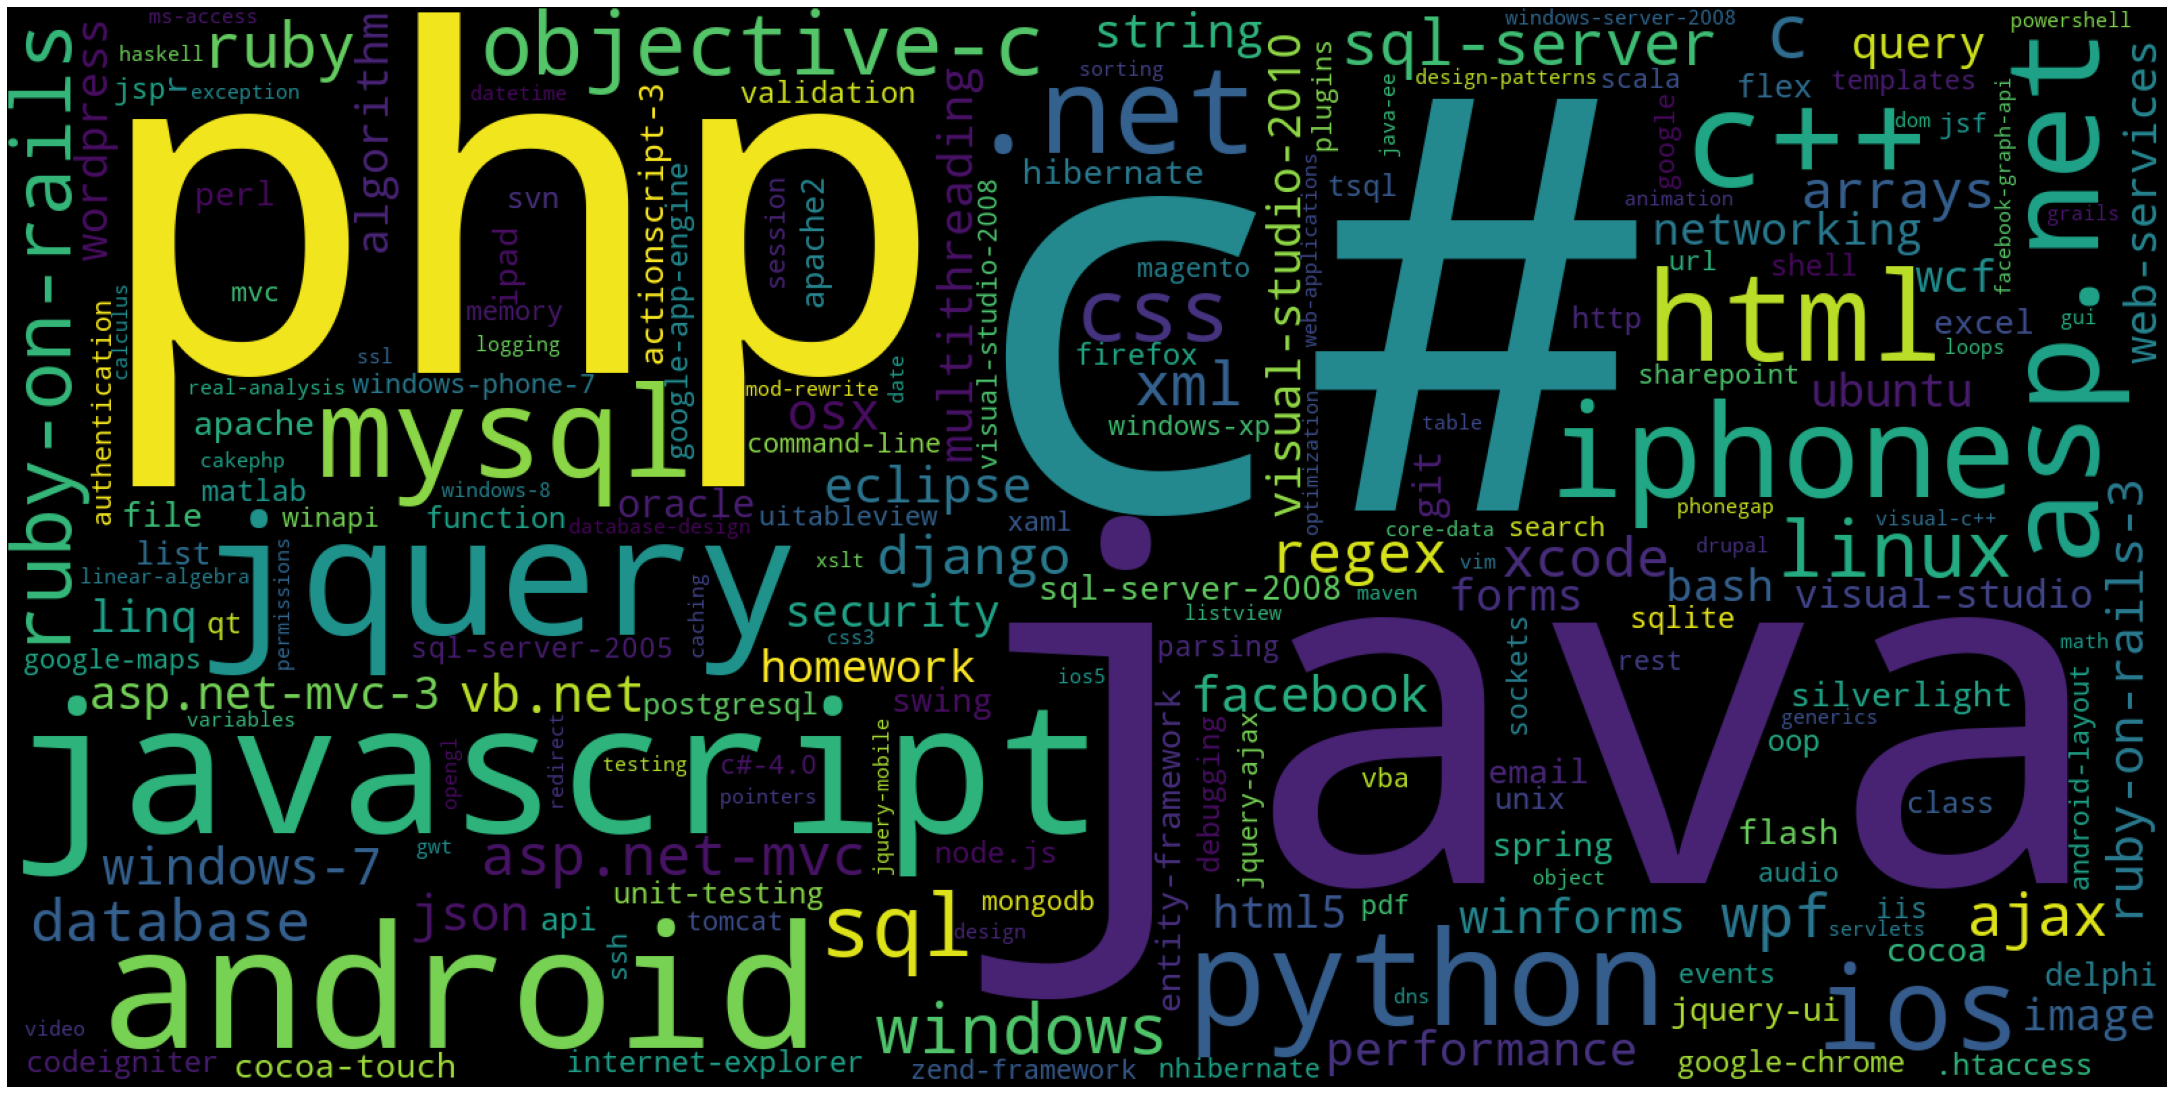

In [23]:
tup = dict(result.items())
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

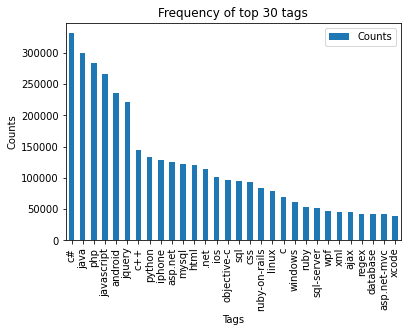

In [27]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(ticks=i,labels=tag_df_sorted['Tags'].head(30))
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

**MAJOR TAKEAWAYS FROM THE ABOVE DATA ANALYSIS**
1. THE TOP TAGS BELONG TO PROGRAMMING LANGUAGES AND INFORMATION TECHNOLOGY SO WE CAN ANALYZE THAT OUR FEATURES SHOULD INCORPORATE THEM ALSO.
2. SOME TAGS ARE VERY FREQUENT THAN OTHERS SO WE HAVE TO DESIGN MODELS WHICH ARE NOT BIASED.